In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import regex as re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jczkr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import os
def get_hashtags_text(x):
    if pd.notna(x) and 'hashtags' in x and x['hashtags']:
        hashtags = x['hashtags']
        hashtags_text = [ht['text'] for ht in hashtags]
        return hashtags_text
    else:
        return None

def get_urls(x):
    if pd.notna(x) and 'urls' in x and x['urls']:
        return True
    return False


def get_user_location(x):
    if pd.notna(x) and 'location' in x:
        return x['location']
    else:
        return None


def load_json(file_path):
    df_new = pd.DataFrame()

    try:
        # Leer el archivo JSON línea por línea y cargar los datos en una lista
        datos_json = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)
                if 'retweeted_status' in data and data['retweeted_status'] != None:
                    data = data['retweeted_status']
                datos_json.append(data)

        df = pd.DataFrame(datos_json)

        df_new['id'] = df['id']
        df_new['lang'] = df['lang']
        df_new['text'] = df['text']
        df_new['favorite_count'] = df['favorite_count']
        df_new['retweet_count'] = df['retweet_count']
        df_new['possibly_sensitive'] = df['possibly_sensitive']
        df_new['created_at'] = df['created_at']
        df_new['is_quote_status'] = df['is_quote_status']
        df_new['entities_hashtags_text'] = df['entities'].apply(get_hashtags_text)
        df_new['entities_urls'] = df['entities'].apply(get_urls)
        df_new['user_location'] = df['user'].apply(get_user_location)
        
        # Asignar 0 a las columnas 'reply_count' y 'quote_count' si no existen
        df_new['reply_count'] = df.get('reply_count', 0)
        df_new['quote_count'] = df.get('quote_count', 0)

        # Verificar si hay al menos una imagen en el JSON
        has_image = []
        for i in range(len(df)):
            try:
                extended_entities = df['extended_entities'][i]
                if 'media' in extended_entities and len(extended_entities['media']) > 0:
                    has_image.append(True)
                else:
                    has_image.append(False)
            except (KeyError, TypeError):
                has_image.append(False)

        df_new['has_image'] = has_image

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_new


def load_jsons_from_folder(folder_path):
    df_all = pd.DataFrame()

    try:
        # Obtener la lista de archivos en la carpeta
        json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

        for file_name in json_files:
            file_path = os.path.join(folder_path, file_name)
            df = load_json(file_path)

            # Extraer el nombre del archivo sin "_final_data.json"
            json_name = file_name.replace('_final_data.json', '')

            # Agregar columna con el nombre del JSON
            df['json_name'] = json_name

            # Concatenar el DataFrame al DataFrame total
            df_all = pd.concat([df_all, df], ignore_index=True)

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_all

def read_tsv_folder(folder_path):
    df_combined = pd.DataFrame()  # DataFrame combinado para almacenar los datos de todos los archivos TSV

    # Obtener la lista de archivos en la carpeta
    file_list = os.listdir(folder_path)

    # Leer cada archivo TSV y combinar los datos en el DataFrame combinado
    for file_name in file_list:
        if file_name.endswith(".tsv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep="\t")
            df_combined = pd.concat([df_combined, df], ignore_index=True)

    return df_combined


In [3]:
irma_json = load_json("RDATA/CrisisMMD_v2.0/json/iraq_iran_earthquake_final_data.json")
irma_tsv = pd.read_table("RDATA/CrisisMMD_v2.0/annotations/iraq_iran_earthquake_final_data.tsv")
harvey_json = load_json("RDATA/CrisisMMD_v2.0/json/hurricane_harvey_final_data.json")
irma_json.T

,0,1,2,3,4,5,6,7,8,9,...,486,487,488,489,490,491,492,493,494,495
id,929945093804617729,929977545260523520,929988832623316993,929896865776259072,929989459453595648,929989477828911104,929966930508775424,929989549895438336,929978536340938754,929989743810576384,...,931664033299738625,931691151236780037,931771549685899264,931789781087981568,931824949509140480,931880697752567808,931898198569996288,931925410224529410,932000082072948736,932027639589507072
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
text,UPDATE:\nDeath toll from Iran’s quake rises to...,We pray for all those affected by the earthqua...,JUST IN: Death toll reaches 328 in Iran earthq...,A magnitude 7.2 earthquake struck northern Ira...,Video: 7.2-magnitude earthquake jolts #Iran-Ir...,#BREAKING: Iran earthquake toll rises to 328 d...,Iran-Iraq border earthquake latest:\n- At leas...,WSJ: Earthquake near Iran-Iraq border kills mo...,Hundreds dead after powerful #earthquake hits ...,Turkey rushes to help Iraq earthquake victims ...,...,@PeterHarley20 @Su39frogfoot @planesonthenet @...,The 2017 Iran-Iraq Earthquake from Sentinel-1....,Less than 24 hours after the earthquake hit #I...,"14 min.ago #earthquake 3.8 has hit Kerman, Ira...",IOC voices readiness to help earthquake-affect...,Damage proxy maps of 5 cities near the epicent...,#Iran Daily: US Treasury Blocks Donations for ...,#Kurdish children's situation after the #earth...,#IRAN'S #EARTHQUAKE EXPOSES #POLITICAL RIFTS A...,Victims of last week's earthquake gather outdo...
favorite_count,10,5,5,2,0,0,61,0,24,0,...,0,0,0,0,0,0,0,0,0,0
retweet_count,23,5,10,3,0,0,121,0,31,0,...,0,0,0,0,0,0,0,0,0,0
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Mon Nov 13 05:32:42 +0000 2017,Mon Nov 13 07:41:39 +0000 2017,Mon Nov 13 08:26:30 +0000 2017,Mon Nov 13 02:21:04 +0000 2017,Mon Nov 13 08:29:00 +0000 2017,Mon Nov 13 08:29:04 +0000 2017,Mon Nov 13 06:59:28 +0000 2017,Mon Nov 13 08:29:21 +0000 2017,Mon Nov 13 07:45:35 +0000 2017,Mon Nov 13 08:30:07 +0000 2017,...,Fri Nov 17 23:23:09 +0000 2017,Sat Nov 18 01:10:55 +0000 2017,Sat Nov 18 06:30:23 +0000 2017,Sat Nov 18 07:42:50 +0000 2017,Sat Nov 18 10:02:35 +0000 2017,Sat Nov 18 13:44:06 +0000 2017,Sat Nov 18 14:53:39 +0000 2017,Sat Nov 18 16:41:46 +0000 2017,Sat Nov 18 21:38:29 +0000 2017,Sat Nov 18 23:28:00 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,[earthquake],None,None,[Iraq],[Iran],[BREAKING],None,None,[earthquake],None,...,None,None,"[Iraq, NiliMajumder]",[earthquake],None,"[Kermanshah, Iran]",[Iran],"[Kurdish, earthquake, Iran]","[IRAN, EARTHQUAKE, POLITICAL, GOVERNANCE]",[Iran]
entities_urls,False,False,False,False,True,False,True,True,True,True,...,False,False,False,True,True,False,True,False,True,False


In [4]:
# Filtrar las filas sin imágenes
#df_without_images = harvey_json.loc[harvey_json['has_image'] == 0]
#df_without_images

df_json = load_jsons_from_folder("RDATA/CrisisMMD_v2.0/json")
df_tsv = read_tsv_folder("RDATA/CrisisMMD_v2.0/annotations")

df_tsv

,tweet_id,image_id,text_info,text_info_conf,image_info,image_info_conf,text_human,text_human_conf,image_human,image_human_conf,image_damage,image_damage_conf,tweet_text,image_url,image_path
0,917791044158185473,917791044158185473_0,informative,1.0000,informative,0.6766,other_relevant_information,1.0000,other_relevant_information,0.6766,NaN,NaN,RT @Gizmodo: Wildfires raging through Northern...,http://pbs.twimg.com/media/DLyi_WYVYAApwNg.jpg,data_image/california_wildfires/10_10_2017/917...
1,917791130590183424,917791130590183424_0,informative,1.0000,informative,0.6667,infrastructure_and_utility_damage,1.0000,affected_individuals,0.6667,NaN,NaN,PHOTOS: Deadly wildfires rage in California ht...,http://pbs.twimg.com/media/DLymKm9UMAAu0qw.jpg,data_image/california_wildfires/10_10_2017/917...
2,917791291823591425,917791291823591425_0,informative,0.6813,informative,1.0000,other_relevant_information,0.6813,infrastructure_and_utility_damage,1.0000,severe_damage,1.0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,http://pbs.twimg.com/media/DLudaaZV4AAjT7x.jpg,data_image/california_wildfires/10_10_2017/917...
3,917791291823591425,917791291823591425_1,informative,0.6813,not_informative,1.0000,other_relevant_information,0.6813,not_humanitarian,1.0000,NaN,NaN,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,http://pbs.twimg.com/media/DLudaZXUMAABAEZ.jpg,data_image/california_wildfires/10_10_2017/917...
4,917792092100988929,917792092100988929_0,informative,0.6727,informative,0.6612,other_relevant_information,0.6727,infrastructure_and_utility_damage,0.6612,severe_damage,1.0,RT @TIME: California's raging wildfires as you...,http://pbs.twimg.com/media/DLwNe-NXUAE0XCw.jpg,data_image/california_wildfires/10_10_2017/917...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18077,881714673157980160,881714673157980160_0,not_informative,1.0000,not_informative,1.0000,not_humanitarian,1.0000,not_humanitarian,1.0000,NaN,NaN,Get to mora and try the whole menu https://t.c...,http://pbs.twimg.com/media/DDx60UAUAAAEGIX.jpg,data_image/srilanka_floods/3_7_2017/8817146731...
18078,881749861871362049,881749861871362049_0,not_informative,1.0000,not_informative,1.0000,not_humanitarian,1.0000,not_humanitarian,1.0000,NaN,NaN,"Mirka Mora (b.1928), noted French-born Austral...",http://pbs.twimg.com/media/DDyavFaWAAEaCuE.jpg,data_image/srilanka_floods/3_7_2017/8817498618...
18079,881770990556131328,881770990556131328_0,not_informative,1.0000,not_informative,1.0000,not_humanitarian,1.0000,not_humanitarian,1.0000,NaN,NaN,"@PaulMalignaggi Lol What u on about, Sergio Mo...",http://pbs.twimg.com/media/DDyuCVoXcAAlfXa.jpg,data_image/srilanka_floods/3_7_2017/8817709905...
18080,881807298930368513,881807298930368513_0,not_informative,0.5056,informative,0.6158,not_humanitarian,0.5056,rescue_volunteering_or_donation_effort,0.6158,NaN,NaN,#Cameroon : 4 #female suicide #Bombers kill 1 ...,http://pbs.twimg.com/media/DDzPED3XgAAynDG.jpg,data_image/srilanka_floods/3_7_2017/8818072989...


In [5]:
df_json

,id,lang,text,favorite_count,retweet_count,possibly_sensitive,created_at,is_quote_status,entities_hashtags_text,entities_urls,user_location,reply_count,quote_count,has_image,json_name
0,917791130590183424,en,PHOTOS: Deadly wildfires rage in California ht...,0,0,False,Tue Oct 10 16:37:11 +0000 2017,False,None,True,"Portland, Maine",0.0,0.0,True,california_wildfires
1,917787635946524674,en,Wildfires raging through Northern California a...,7,5,False,Tue Oct 10 16:23:18 +0000 2017,False,None,True,None,0.0,4.0,True,california_wildfires
2,917500054742605829,en,"PLS SHARE: We’re capturing wildfire response, ...",289,479,False,Mon Oct 09 21:20:34 +0000 2017,False,None,True,"Sacramento, California",9.0,25.0,True,california_wildfires
3,917623252264062976,en,California's raging wildfires as you've never ...,228,216,False,Tue Oct 10 05:30:06 +0000 2017,False,None,True,None,19.0,18.0,True,california_wildfires
4,917792930315821057,en,Mass Evacuations in California as Wildfires Ki...,0,0,False,Tue Oct 10 16:44:21 +0000 2017,False,[CaliforniaWildfires],True,www.facebook.com/doctorreefer/,0.0,0.0,True,california_wildfires
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16052,881714673157980160,en,Get to mora and try the whole menu https://t.c...,0,0,False,Mon Jul 03 03:22:14 +0000 2017,False,None,False,"Arizona, USA",0.0,0.0,True,srilanka_floods
16053,881749861871362049,en,"Mirka Mora (b.1928), noted French-born Austral...",0,0,False,Mon Jul 03 05:42:03 +0000 2017,False,[womensart],False,None,0.0,0.0,True,srilanka_floods
16054,881770990556131328,en,"@PaulMalignaggi Lol What u on about, Sergio Mo...",0,0,False,Mon Jul 03 07:06:01 +0000 2017,False,None,False,None,0.0,0.0,True,srilanka_floods
16055,881807298930368513,en,#Cameroon : 4 #female suicide #Bombers kill 1 ...,0,0,False,Mon Jul 03 09:30:17 +0000 2017,False,"[Cameroon, female, Bombers]",True,Cameroon,0.0,0.0,True,srilanka_floods


In [6]:
df = pd.merge(df_json, df_tsv[['tweet_id', 'text_info', 'text_info_conf', 'text_human', 'text_human_conf']],
                    left_on='id', right_on='tweet_id', how='left')
df.drop('tweet_id',axis=1,inplace=True)
df =  df[df['text_human'].notna()]
df.T



,0,4,5,7,9,10,11,12,13,16,...,17621,17622,17623,17624,17625,17626,17627,17628,17629,17630
id,917791130590183424,917792930315821057,917792147700465664,917794232160661505,917793736918216706,917793881533571073,917794024173563904,917794580728295424,917794360581869569,917795236595863552,...,881571538364801024,881612317317836800,881612317317836800,881612317317836800,881612317317836800,881632991776301056,881714673157980160,881749861871362049,881770990556131328,881807298930368513
lang,en,en,en,en,en,en,en,en,en,en,...,en,en,en,en,en,en,en,en,en,en
text,PHOTOS: Deadly wildfires rage in California ht...,Mass Evacuations in California as Wildfires Ki...,Wildfires Threaten California’s First Legal Ca...,At Least 11 Dead and 100 Missing as Wildfires ...,California wildfire. ὡ4 https://t.co/a8oD5rkDdI,Wildfires Still Burn in Northern California; 1...,"Henry Cejudo suffers burns, loses gold medal i...",More than 100 missing persons reports made in ...,Southern California wildfires continue to rage...,"11 dead, thousands homeless as wildfires torch...",...,"Congratulations on a beautiful wedding, Coach ...","Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...","Mora, Lakin, Immaris, and our DM are officiall...",https://t.co/7VqAlUWTUO My #wine tip for this ...,Get to mora and try the whole menu https://t.c...,"Mirka Mora (b.1928), noted French-born Austral...","@PaulMalignaggi Lol What u on about, Sergio Mo...",#Cameroon : 4 #female suicide #Bombers kill 1 ...
favorite_count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
retweet_count,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
possibly_sensitive,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
created_at,Tue Oct 10 16:37:11 +0000 2017,Tue Oct 10 16:44:21 +0000 2017,Tue Oct 10 16:41:14 +0000 2017,Tue Oct 10 16:49:31 +0000 2017,Tue Oct 10 16:47:33 +0000 2017,Tue Oct 10 16:48:07 +0000 2017,Tue Oct 10 16:48:41 +0000 2017,Tue Oct 10 16:50:54 +0000 2017,Tue Oct 10 16:50:02 +0000 2017,Tue Oct 10 16:53:30 +0000 2017,...,Sun Jul 02 17:53:28 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 20:35:30 +0000 2017,Sun Jul 02 21:57:39 +0000 2017,Mon Jul 03 03:22:14 +0000 2017,Mon Jul 03 05:42:03 +0000 2017,Mon Jul 03 07:06:01 +0000 2017,Mon Jul 03 09:30:17 +0000 2017
is_quote_status,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
entities_hashtags_text,None,[CaliforniaWildfires],None,None,None,[nyt],None,None,None,"[Heatwave, Wildfires]",...,None,None,None,None,None,"[wine, weekend]",None,[womensart],None,"[Cameroon, female, Bombers]"
entities_urls,True,True,True,False,False,True,True,True,True,True,...,False,False,False,False,False,True,False,False,False,True


In [7]:
summary = df.describe()
summary

,id,favorite_count,retweet_count,reply_count,quote_count,text_info_conf,text_human_conf
count,1.547700e+04,15477.000000,15477.000000,15259.000000,15260.000000,15477.000000,15477.000000
mean,9.108053e+17,0.035472,0.014667,0.012976,0.006881,0.798199,0.798199
std,1.150900e+16,4.224428,1.706450,1.547251,0.833952,0.201253,0.201253
min,8.699501e+17,0.000000,0.000000,0.000000,0.000000,0.257800,0.257800
25%,9.075860e+17,0.000000,0.000000,0.000000,0.000000,0.660800,0.660800
50%,9.101684e+17,0.000000,0.000000,0.000000,0.000000,0.708800,0.708800
75%,9.162843e+17,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.320276e+17,525.000000,212.000000,191.000000,103.000000,1.000000,1.000000


In [8]:
# select only numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# select only non-numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

boolean_columns = df.select_dtypes(include=['bool']).columns.tolist()

print(numerical_columns)

print(categorical_columns)

print(boolean_columns)

['id', 'favorite_count', 'retweet_count', 'reply_count', 'quote_count', 'text_info_conf', 'text_human_conf']
['lang', 'text', 'created_at', 'is_quote_status', 'entities_hashtags_text', 'user_location', 'json_name', 'text_info', 'text_human']
['possibly_sensitive', 'entities_urls', 'has_image']


### Se revisa si hay ids repetidos

In [9]:
print(df["id"].shape)
df["id"].value_counts()

(15477,)


id
909754460745945088    8
908525619037732865    4
906689052132368384    4
869972354004393987    4
912204795427123200    4
                     ..
905647896330084353    1
905652347296198656    1
905652947534585857    1
905653129298849792    1
881807298930368513    1
Name: count, Length: 13899, dtype: int64

In [10]:
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
print(df.shape)
df["id"].value_counts()

(13899, 19)


id
917791130590183424    1
913526987720921088    1
913501170173337600    1
913503821971603457    1
913507924030492672    1
                     ..
910156535011135488    1
910159570353491969    1
910160558011318279    1
910160788849008640    1
881807298930368513    1
Name: count, Length: 13899, dtype: int64

Con los datos no duplicados, se revisa la variedad de ciertas columnas. Si estás columnas solo retornan un único valor, se eliminan por redundancia.


In [11]:
language = df["lang"]

wa = []

for i in language:
    if i not in wa:
        wa.append(i)

print(wa)

['en']


### Contando valores 

In [12]:


count_retweet_not_zero = len(df[(df['retweet_count'] >= 1)])
count_favorite_not_zero = len(df[(df['favorite_count'] >= 1)])
reply_counts = len(df[(df['reply_count'] >= 1)])
quote_counts = len(df[(df['quote_count'] >= 1)])

# Contar la cantidad de tweets con retweet_count igual a 0
count_retweet_zero = len(df[df['retweet_count'] == 0])

# Contar la cantidad de tweets con favorite_count igual a 0
count_favorite_zero = len(df[df['favorite_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
reply_counts_zero = len(df[df['reply_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
quote_counts_zero = len(df[df['quote_count'] == 0])

# Contar la cantidad de tweets con is_quote_status = True
count_quote_true = len(df[df['is_quote_status'] == True])

# Contar la cantidad de tweets con is_quote_status = False
count_quote_false = len(df[df['is_quote_status'] == False])

# Contar la cantidad de tweets con possibly_sensitive = True
count_sensitive_true = len(df[df['possibly_sensitive'] == True])

# Contar la cantidad de tweets con possibly_sensitive = False
count_sensitive_false = len(df[df['possibly_sensitive'] == False])

print("Cantidad de tweets con retweet_count > 1:", count_retweet_not_zero)
print("Cantidad de tweets sin retweet_count:", count_retweet_zero)
print("Cantidad de tweets con favorite_count > 1:", count_favorite_not_zero)
print("Cantidad de tweets sin favorite_count:", count_favorite_zero)
print("Cantidad de tweets con reply_count > 1:", reply_counts)
print("Cantidad de tweets sin reply_count:", reply_counts_zero)
print("Cantidad de tweets con quote_count > 1:", quote_counts)
print("Cantidad de tweets sin quote_count:", quote_counts_zero)
print("Cantidad de tweets con is_quote_status = True:", count_quote_true)
print("Cantidad de tweets con is_quote_status = False:", count_quote_false)
print("Cantidad de tweets con possibly_sensitive = True:", count_sensitive_true)
print("Cantidad de tweets con possibly_sensitive = False:", count_sensitive_false)

print("")
print(f"Hay un {round((count_retweet_zero / (count_retweet_zero+count_retweet_not_zero))*100,2)} % de los tweets sin favoritos")
print(f"Hay un {round((count_favorite_zero / (count_favorite_zero+count_favorite_not_zero)) *100,2)} % de los tweets sin RTs")
print(f"Hay un {round((reply_counts_zero / (reply_counts_zero+reply_counts))*100,2)} % de los tweets sin respuestas(?)")
print(f"Hay un {round((quote_counts_zero / (quote_counts_zero+quote_counts)) *100,2)} % de los tweets sin citados")
print(f"Hay un {round((count_quote_false / (count_quote_false+count_quote_true))*100,2)} % de los tweets no citados")
print(f"Hay un {round((count_sensitive_false / (count_sensitive_false+count_sensitive_true)) *100,2)} % de los tweets no sensibles")


Cantidad de tweets con retweet_count > 1: 1
Cantidad de tweets sin retweet_count: 13898
Cantidad de tweets con favorite_count > 1: 0
Cantidad de tweets sin favorite_count: 13899
Cantidad de tweets con reply_count > 1: 0
Cantidad de tweets sin reply_count: 13703
Cantidad de tweets con quote_count > 1: 0
Cantidad de tweets sin quote_count: 13704
Cantidad de tweets con is_quote_status = True: 91
Cantidad de tweets con is_quote_status = False: 13807
Cantidad de tweets con possibly_sensitive = True: 110
Cantidad de tweets con possibly_sensitive = False: 13789

Hay un 99.99 % de los tweets sin favoritos
Hay un 100.0 % de los tweets sin RTs
Hay un 100.0 % de los tweets sin respuestas(?)
Hay un 100.0 % de los tweets sin citados
Hay un 99.35 % de los tweets no citados
Hay un 99.21 % de los tweets no sensibles


       quote_count  favorite_count  reply_count  retweet_count
count      13704.0         13899.0      13703.0   13899.000000
mean           0.0             0.0          0.0       0.000072
std            0.0             0.0          0.0       0.008482
min            0.0             0.0          0.0       0.000000
25%            0.0             0.0          0.0       0.000000
50%            0.0             0.0          0.0       0.000000
75%            0.0             0.0          0.0       0.000000
max            0.0             0.0          0.0       1.000000


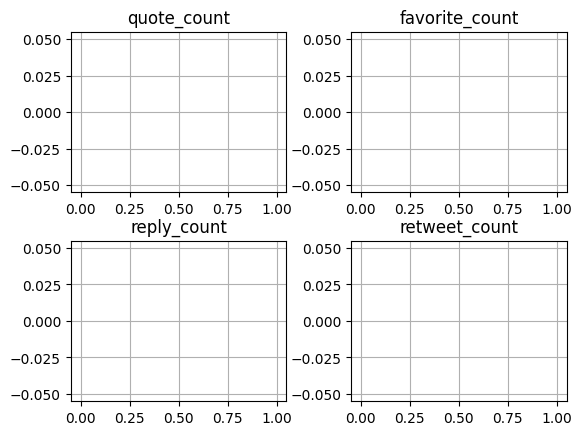

In [13]:
def hist_interaction(df):
    print(df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].describe())
    new_df = df[df['retweet_count'] > 50]
    new_df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].hist()

hist_interaction(df)

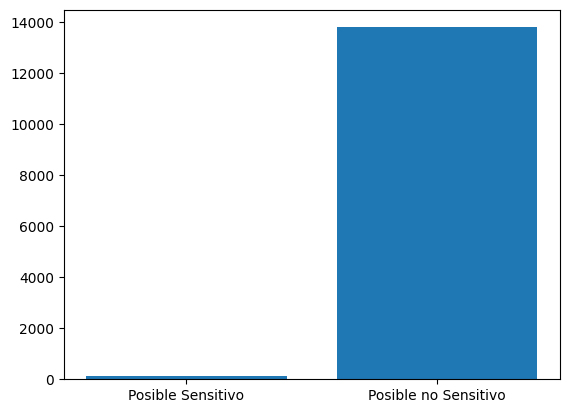

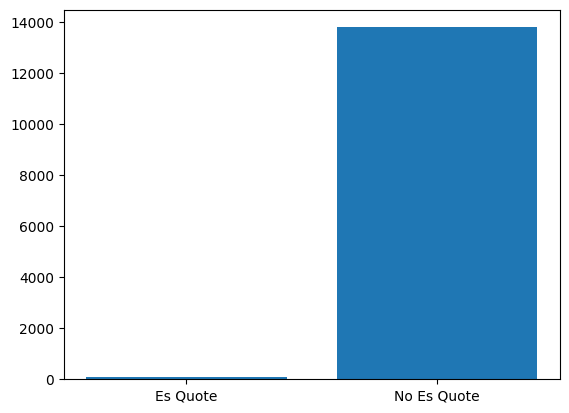

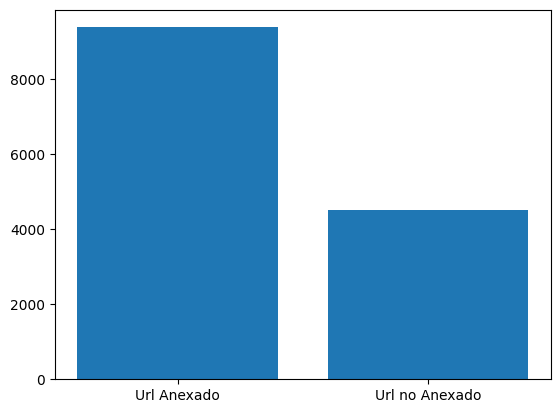

In [14]:
def count_booleans(df):
    valores_T = 0
    valores_F = 0
    quoteable = 0
    not_quotable = 0
    url = 0
    urlnt = 0

    for i in range(df.shape[0]):
        if df["possibly_sensitive"][i]:
            valores_T +=1
        else:
            valores_F +=1

        if df["is_quote_status"][i]:
            quoteable += 1
        else:
            not_quotable += 1        

        if df["entities_urls"][i]:
            url += 1
        else:
            urlnt += 1

    plt.bar(["Posible Sensitivo","Posible no Sensitivo"],[valores_T, valores_F])
    plt.show()

    plt.bar(["Es Quote","No Es Quote"],[quoteable, not_quotable])
    plt.show()

    plt.bar(["Url Anexado","Url no Anexado"],[url, urlnt])
    plt.show()

count_booleans(df)

Se procede a analizar los tweets si son informativos y si son humanitarios. Se separan en grupos según el valor 'conf'. Si 'conf' es 1, se grafican los valores como tal. Si 'conf' es menor a 1, se gráfica junto al promedio de conf.


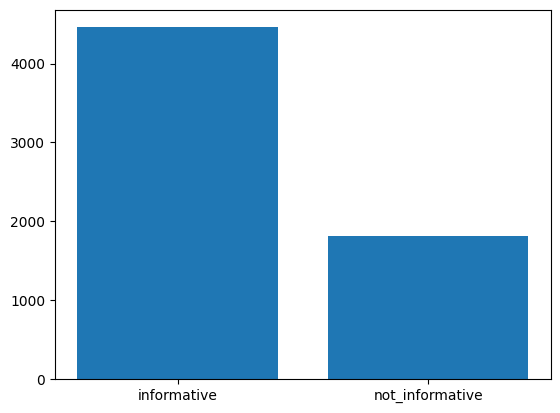

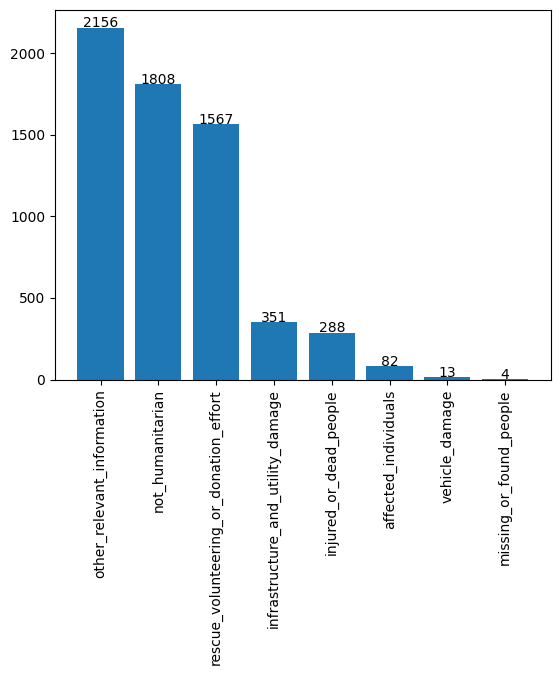

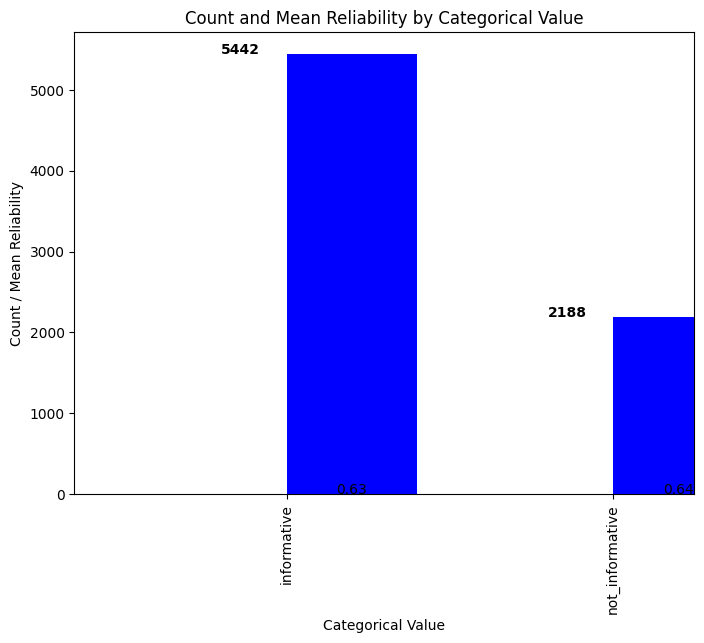

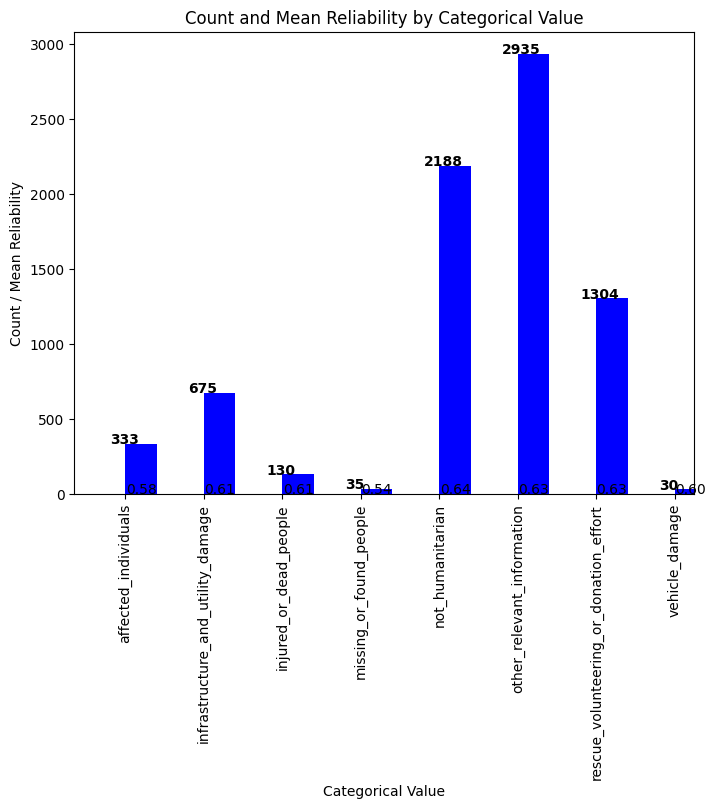

In [15]:
def info_and_human(df):
    
    #se copia la dataframe
    df_info = df.copy()
    df_human = df.copy()

    #se borran los archivos NaN correspondientes
    df_info = df_info[df_info['text_info'].notna()]
    df_info = df_info[df_info['text_info_conf'].notna()]
    df_human = df_human[df_human['text_human'].notna()]
    df_human = df_human[df_human['text_human_conf'].notna()]

    #se reinicia la index si necesario
    df_info.reset_index(inplace=True, drop=True)
    df_human.reset_index(inplace=True, drop=True)

    #se crea nueva id según index
    df_info["new_id"] = df_info.index
    df_human["new_id"] = df_human.index

    
    #se crean dataframes para separar conf=1 con conf<1
    info_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()
    info_casi_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()

    wanted = []
    not_wanted = []

    i = 0
    while i < info_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if info_confiable["text_info_conf"][i] < 1:
            not_wanted.append(info_confiable["new_id"][i])
        else:
            wanted.append(info_confiable["new_id"][i])
        i += 1


    for j in not_wanted:
        info_confiable = info_confiable.drop(info_confiable[info_confiable["new_id"]==j].index)

    for k in wanted:
        info_casi_confiable = info_casi_confiable.drop(info_casi_confiable[info_casi_confiable["new_id"]==k].index)


    #se crean dataframes para separar conf=1 con conf<1
    human_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()
    human_casi_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()

    hwanted = []
    not_hwanted = []

    i = 0
    while i < human_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if human_confiable["text_human_conf"][i] < 1:
            not_hwanted.append(human_confiable["new_id"][i])
        else:
            hwanted.append(human_confiable["new_id"][i])
        i += 1


    for j in not_hwanted:
        human_confiable = human_confiable.drop(human_confiable[human_confiable["new_id"]==j].index)

    for k in hwanted:
        human_casi_confiable = human_casi_confiable.drop(human_casi_confiable[human_casi_confiable["new_id"]==k].index)


    valores_info_confiable = info_confiable["text_info"].value_counts()

    plt.bar(valores_info_confiable.index, valores_info_confiable.values)

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.show()

    valores_human_confiable = human_confiable["text_human"].value_counts()

    plt.bar(valores_human_confiable.index, valores_human_confiable.values)

    for i, v in enumerate(valores_human_confiable.values):
        plt.text(i, v + 1, str(v), ha="center")

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.xticks(rotation=90)

    plt.show()


    # calculate counts and means
    counts = info_casi_confiable['text_info'].value_counts().sort_index()
    means = info_casi_confiable.groupby('text_info')['text_info_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

    # calculate counts and means
    counts = human_casi_confiable['text_human'].value_counts().sort_index()
    means = human_casi_confiable.groupby('text_human')['text_human_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

info_and_human(df)

In [16]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

text_data = df['text'].str.split().tolist()
all_words = [word.lower() for sublist in text_data for word in sublist]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jczkr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jczkr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
stopwords_en = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stopwords_en]
word_counter = Counter(filtered_words)
top_words = word_counter.most_common(90)  # Puedes ajustar el número de palabras que deseas mostrar


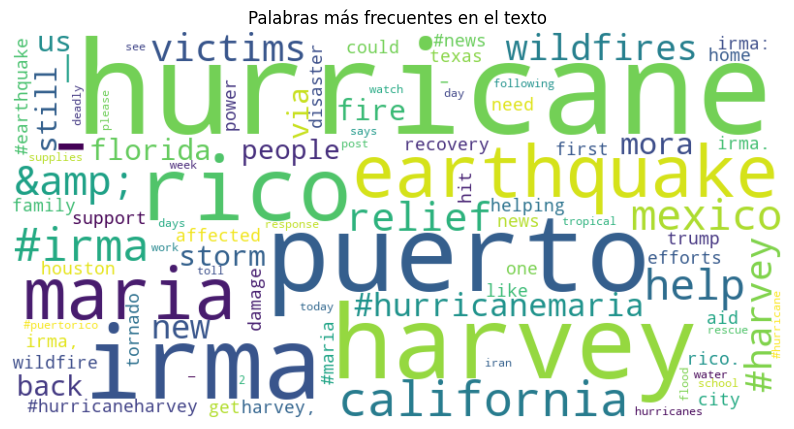

In [18]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más frecuentes en el texto')
plt.show()


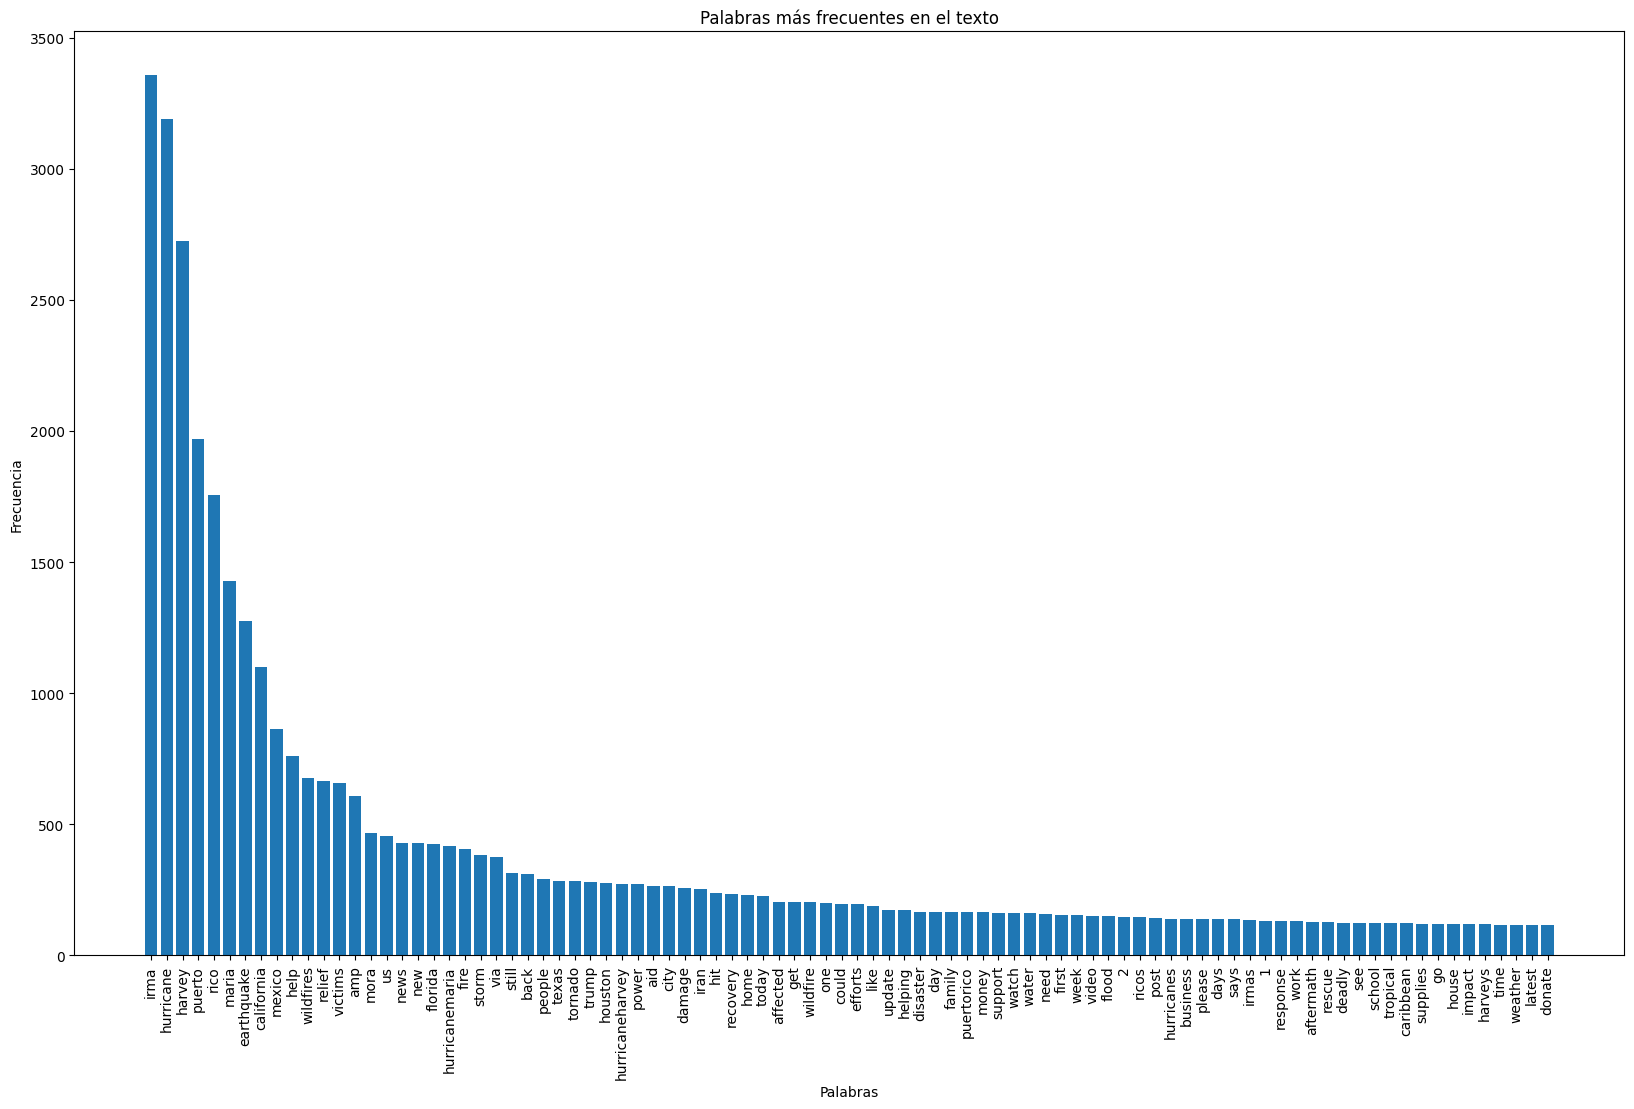

In [19]:

# Obtener las stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función para limpiar y tokenizar el texto
def clean_and_tokenize(text):
    # Quitar caracteres especiales y símbolos "#" pegados a las palabras
    text = re.sub(r'[^\w\s]|#(?=\w)', '', text)
    # Tokenizar el texto en palabras
    tokens = word_tokenize(text.lower())
    # Quitar las stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Obtener las palabras y sus frecuencias en la columna "text"
words = df['text'].apply(clean_and_tokenize).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()


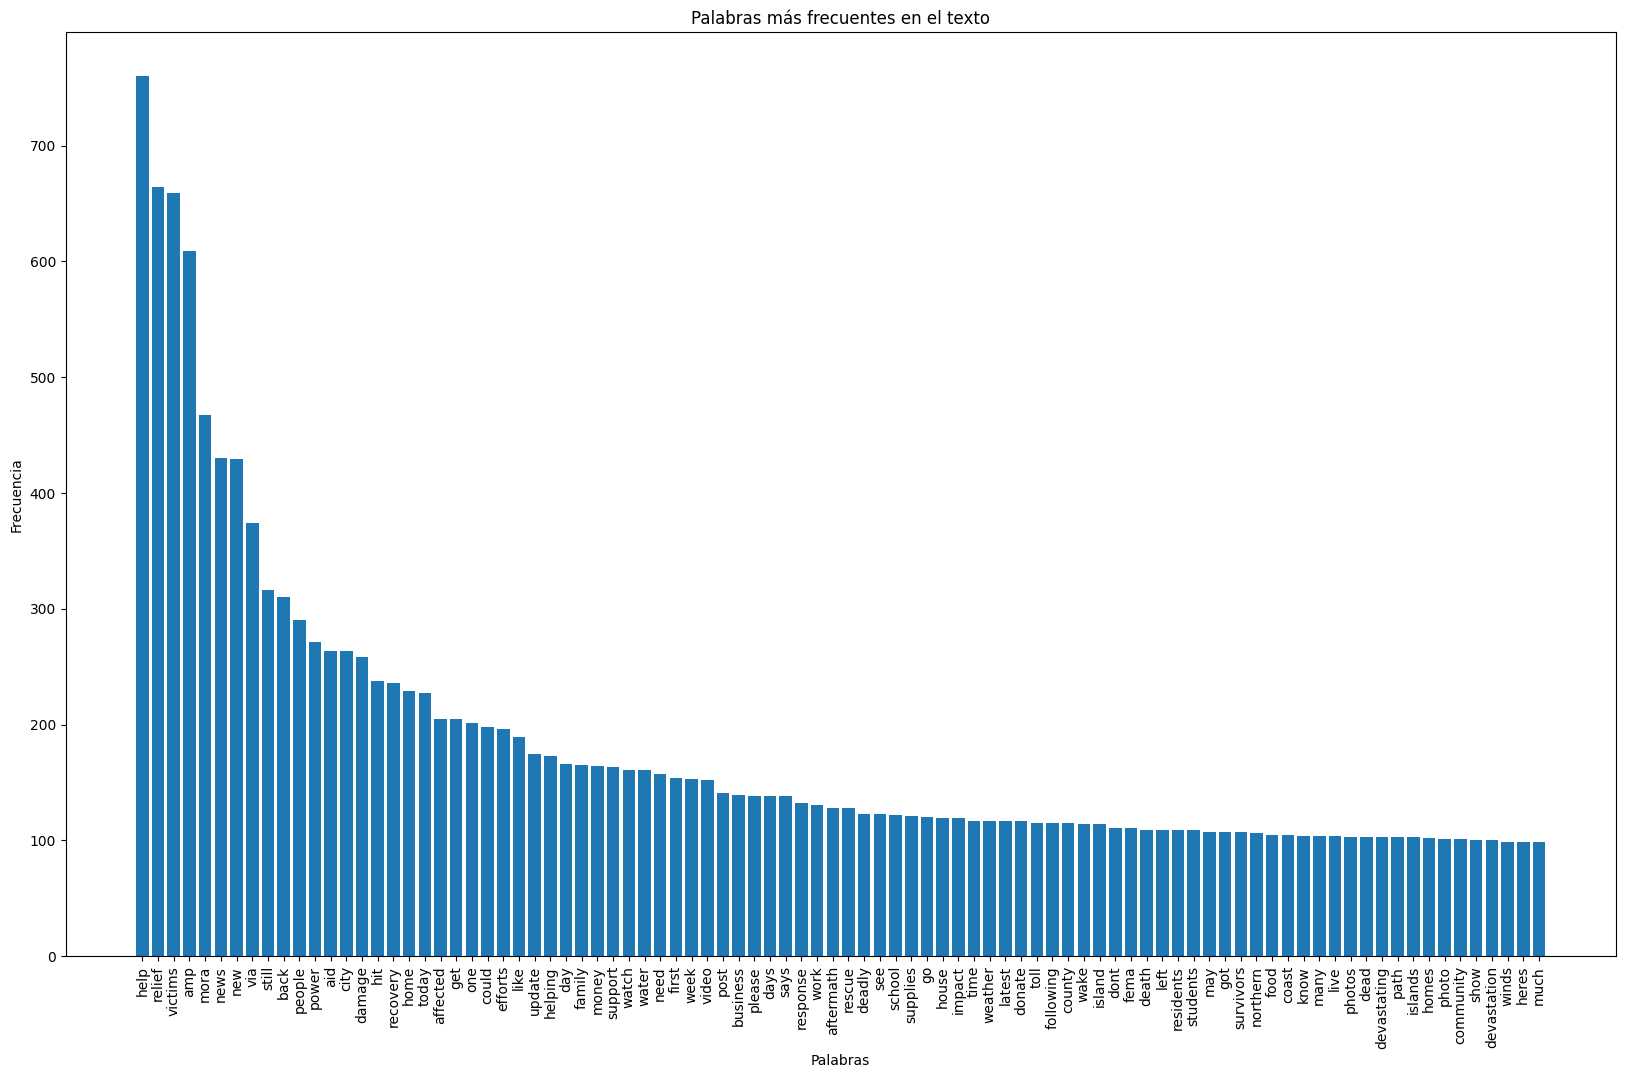

In [20]:

def clean_and_tokenize2(text):
    # Eliminar caracteres especiales y hashtags pegados a palabras
    cleaned_text = re.sub(r"[^\w\s]|(#\w+)", "", text)

    # Tokenizar el texto
    tokens = word_tokenize(cleaned_text.lower())

    # Eliminar stopwords en inglés y palabras adicionales
    stop_words = set(stopwords.words('english'))
    additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st']
    stop_words.update(additional_stop_words)

    # Agregar números a la lista de stopwords
    stop_words.update(additional_stop_words)
    stop_words.update(set(token for token in tokens if token.isdigit()))

    # Filtrar las palabras
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens

# Obtener las palabras y sus frecuencias en la columna "text"
words = df['text'].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

In [25]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopword_tokens
import numpy as np


# Supongamos que tienes una lista de oraciones en la columna de texto
sentences = df["text"].tolist()

stop_words = set(stopwords.words('english'))
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st']
stop_words.update(additional_stop_words)

# Tokeniza las oraciones y crea una lista de listas de palabras
#tokenized_sentences = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in sentences]


# Definir los parámetros del modelo Word2Vec
vector_size = 100  # Dimensión del espacio vectorial
window_size = 5  # Tamaño de la ventana de contexto
min_count = 1  # Frecuencia mínima de las palabras para ser consideradas

def cargar_embeddings_glove(ruta_archivo):
    embeddings_index = {}
    with open(ruta_archivo, encoding='utf-8') as archivo:
        for linea in archivo:
            valores = linea.split()
            palabra = valores[0]
            vector = np.asarray(valores[1:], dtype='float32')
            embeddings_index[palabra] = vector
    return embeddings_index

ruta_archivo_glove = "glove/glove.6B.200d.txt"  # Reemplaza con la ruta real de tu archivo GloVe
embeddings_glove = cargar_embeddings_glove(ruta_archivo_glove)

# Crear y entrenar el modelo
#model = Word2Vec(tokenized_sentences, vector_size=vector_size, window=window_size, min_count=min_count)

# Obtén el vector de una palabra específica
# word = "help"
# vector = model.wv[word]
# print(f"Vector de '{word}': {vector}")

# Encuentra palabras similares a una palabra dada
# similar_words = model.wv.most_similar(word)
# print(f"Palabras similares a '{word}': {similar_words}")



In [26]:
from sklearn.model_selection import train_test_split

# Carga el dataset en un DataFrame de pandas

# Divide los datos en características (X) y etiquetas (y)
X = df['text'].values  # Reemplaza 'columna_de_texto' con el nombre real de tu columna
y = df['text_human'].values  # Reemplaza 'columna_etiquetas' con el nombre real de tu columna de etiquetas

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
from gensim.utils import simple_preprocess
from spacy.lang.en.stop_words import STOP_WORDS
import numpy as np

stop_words = STOP_WORDS
additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st']
stop_words.update(additional_stop_words)

tokenized_sentences_train = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_train]
tokenized_sentences_test = [remove_stopword_tokens(simple_preprocess(sentence), stop_words) for sentence in X_test]

# vectors_train = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_train]
# vectors_test = [[model.wv[word] for word in sentence] for sentence in tokenized_sentences_test]

vectors_train = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_train]
vectors_test = [[embeddings_glove[word] if word in embeddings_glove else np.zeros(200) for word in sentence] for sentence in tokenized_sentences_test]


def average_vectors(vectors):
    averaged_vectors = []
    for sentence_vectors in vectors:
        if len(sentence_vectors) > 0:
            averaged_vectors.append(np.mean(sentence_vectors, axis=0))
        else:
            averaged_vectors.append(np.zeros(200))
    return averaged_vectors

X_train_embeddings = average_vectors(vectors_train)
X_test_embeddings = average_vectors(vectors_test)


In [28]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train_embeddings, y_train)

y_pred = classifier.predict(X_test_embeddings)


In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6025179856115108
Precision: 0.5074508838881426
Recall: 0.41840021678199707
F1 Score: 0.4350877586762865
